# AutoEncoders for MD Analysis tutorial using BioExcel Building Blocks (biobb)

***
This tutorial involves the use of a **multilayer AutoEncoder (AE)** for **feature extraction** and **pattern recognition** by analyzing **Molecular Dynamic Simulations**, step by step, using the **BioExcel Building Blocks library (biobb)**.

The workflow begins with **featurization** using `MDFeaturizer` to extract structural descriptors (e.g., distances, angles, dihedrals, or Cartesian coordinates) from MD trajectories. Next, `buildModel` constructs a **multilayer AutoEncoder architecture**. The model is then trained with `trainModel` to **learn the dynamics** and **compressed representation** of **conformational dynamics**. After training, `evaluateModel` assesses reconstruction accuracy and latent space quality (using different datasets). Finally, `generatePlumed` converts the trained model into a **PLUMED-compatible format** (*.ptc*) and generates bias-ready input files for **enhanced sampling simulations**. This pipeline enables analysis with autoencoders for anomaly detection, identifying rare or perturbed dynamics, dynamical differences mapping, and the extration of  **collective variables (CVs)** for **enhanced sampling simulations**.

***

**MD simulations** were obtained from the [MDDB Database](https://mmb-dev.mddbr.eu/)
* **Replicase polyprotein 1ab** (PDB: [6W9C](https://www.rcsb.org/structure/6W9C)):
   1. **apo form**    (No ligands)
   2. **holo form** (Ligand: [3KB](https://www.rcsb.org/ligand/3KB)).

***


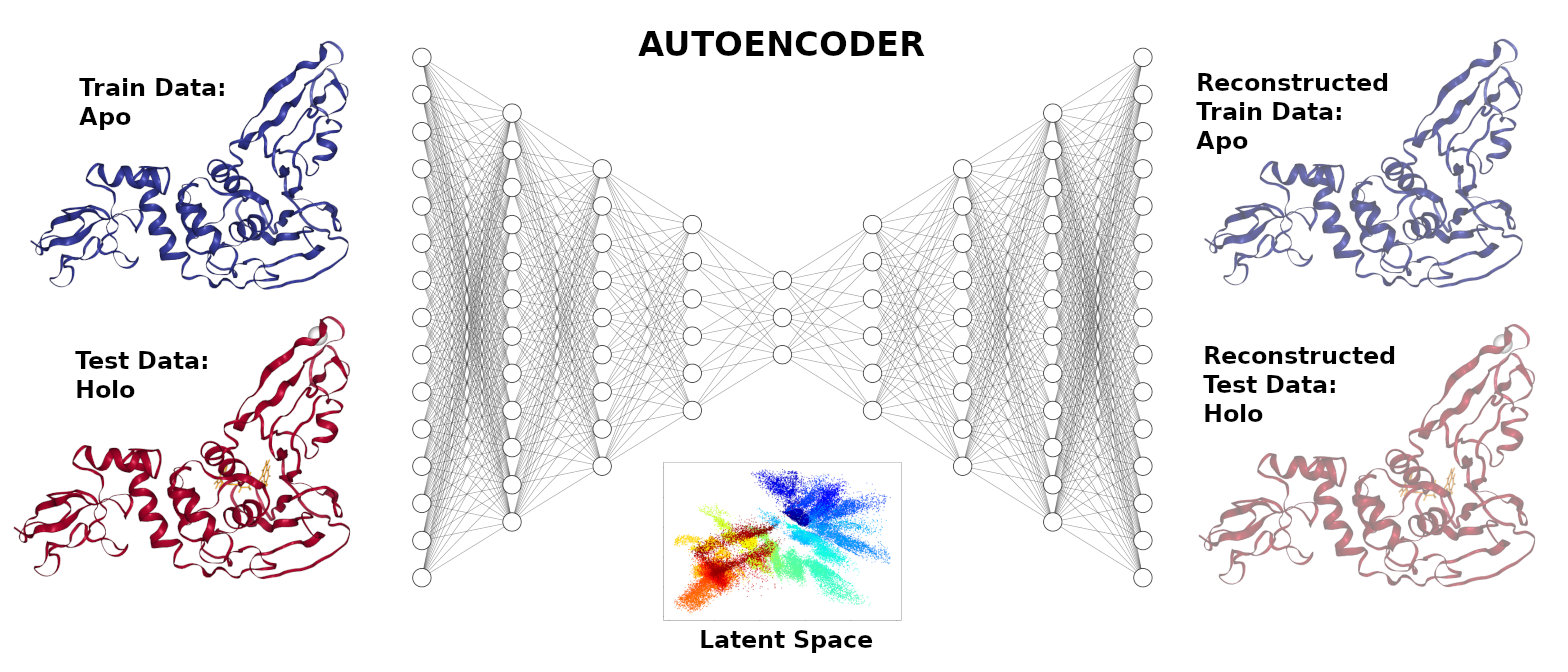

***
## Settings

### Biobb modules used

* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch): module collection to create and train ML & DL models using the popular PyTorch Python library.

### Auxiliary libraries used

* [jupyter](https://jupyter.org/): Free software, open standards, and web services for interactive computing across all programming languages.
* [nglview](http://nglviewer.org/#nglview): Jupyter/IPython widget to interactively view molecular structures and trajectories in notebooks.
* [numpy](https://numpy.org/): The fundamental package for scientific computing with Python.
* [mdtraj](https://www.mdtraj.org/): Read, write and analyze MD trajectories with only a few lines of Python code.
* [requests](https://requests.readthedocs.io/en/latest/): Requests is an elegant and simple HTTP library for Python, built for human beings.
* [matplotlib](https://matplotlib.org/): Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.

> **IMPORTANT**: if your computer is a **mac ARM**, please be sure that the chosen architecture in conda is **ARM**. If not sure, type the following instruction in your terminal **before** starting the creation of the **environment**: <br>
`conda config --env --set subdir osx-arm64` <br>
This instruction ensures that the installed **torch** dependency will match your **architecture**.

### Conda Installation and Launch

```console
git clone https://github.com/bioexcel/biobb_wf_autoencoder.git
cd biobb_wf_autoencoder
conda env create -f conda_env/environment.yml
conda activate biobb_wf_autoencoder
jupyter-notebook biobb_wf_autoencoder/notebooks/biobb_wf_autoencoder.ipynb
```

***
## Pipeline steps
 1. [Input Parameters](#input)
 2. [Featurization of Training dataset](#featurize1)
 3. [Build Model](#build-model)
 4. [Train Model](#train-model)
 5. [Featurization of Evaluation dataset](#featurize2)
 6. [Evaluate Model](#evaluate-model)   
 7. [Case Study: Dynamical Differences Mapping](#case-study1)
 8. [Extract CV & Generate Plumed File](#cv-plumed)
 9. [Questions & Comments](#questions)

***
<img src="https://bioexcel.eu/wp-content/uploads/2019/04/Bioexcell_logo_1080px_transp.png" alt="Bioexcel2 logo"
	title="Bioexcel2 logo" width="400" />
***


## Initializing colab
The two cells below are used only in case this notebook is executed via Google Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import sys
REPO_URL = "https://github.com/bioexcel/biobb_wf_autoencoder.git"
repo_name = REPO_URL.split('/')[-1].split('.')[0]
# Clone repository
if not os.path.exists(repo_name):
  !git clone $REPO_URL
os.chdir(repo_name)

!apt install gromacs &> /dev/null
!pip install mlcolvar mdtraj biobb_common biobb_gromacs nglview==3.0.8 ipywidgets==7.7.2 &> /dev/null
!pip install git+https://github.com/bioexcel/biobb_analysis.git &> /dev/null
!pip install git+https://github.com/bioexcel/biobb_pytorch.git &> /dev/null
from google.colab import output
output.enable_custom_widget_manager()

***
<a id="input"></a>
## Input parameters

**Input parameters** needed:
  - **Training Data**:
    - **trj_in**: Path to input XTC trajectory file.
    - **str_in**: Path to input PDB topology file.
  - **Testing Data**:
    - **test_trj_in**: Path to input XTC trajectory file.
    - **test_str_in**: Path to input PDB topology file.


In [ ]:
# Importing libraries
import numpy as np
import mdtraj as md
import nglview as nv
from biobb_pytorch.mdae import plots
import requests
from pathlib import Path

# Trajectory and structure files for training
trj_in = "trajs/6W9C_apo.xtc"
str_in = "trajs/6W9C_apo.pdb"

# Trajectory and structure files for testing
test_trj_in = "trajs/6W9C_holo.xtc"
test_str_in = "trajs/6W9C_holo.pdb"

***
<a id="featurize1"></a>
## Featurization of Training dataset

**Downloading** the **trajectory** and **structure** for **Training**.

Trajectories where obtained from the [MDDB database](https://mmb-dev.mddbr.eu/#/).


In [ ]:
# Downloading trajectory and structure for training
traj_train_URL = "https://mmb.mddbr.eu/api/rest/v1/projects/MCV1900210/trajectory?format=xtc&frames=1-10000&selection=backbone%20and%20.CA"
pdb_train_URL = "https://mmb.mddbr.eu/api/rest/v1/projects/MCV1900210/structure?selection=backbone%20and%20.CA"
traj_train_path = trj_in
structure_train_path = str_in
Path(traj_train_path).parent.mkdir(parents=True, exist_ok=True)
req = requests.get(pdb_train_URL, allow_redirects=True)
open(structure_train_path, 'wb').write(req.content)
req = requests.get(traj_train_URL, allow_redirects=True)
open(traj_train_path, 'wb').write(req.content)

# Load trajectory
train_traj = md.load(traj_train_path, top=structure_train_path)


**Downloading** the **trajectory** and **structure** for **evaluation**.

Trajectories where obtained from the [MDDB database](https://mmb-dev.mddbr.eu/#/).


Visualizing the **testing trajectory** using **NGL**:

In [ ]:
# Show trajectory
view = nv.show_mdtraj(train_traj)
view

### MD Featurization

**Input parameters** needed:

* **input_trajectory_path** *(str)*: Path to the input train data file (i.e. pdb, dcd).
* **input_topology_path** *(str)*: Path to the input model file (i.e. pdb).
* **output_dataset_pt_path** *(str)*: Path to the output model file.
* **output_stats_pt_path** *(str)*: Path to the output model statistics file.

**properties parameters**:
>* **cartesian** (*dict*): select the atoms for obtaining cartesian coordinates
>* **distances** (*dict*): select the atoms for obtaining distances
>* **angles** (*dict*): select the atoms for obtaining angles
>* **dihedrals** (*dict*): select the atoms for obtaining dihedrals
>* **options** (*dict*):
    > * timelag (*int*)
    > * norm_in (*str*)



In [ ]:
from biobb_pytorch.mdae.mdfeaturizer import MDFeaturizer

# Input files
trajectory_file = traj_train_path
topology_file = structure_train_path

# Output files
output_dataset_file = "6W9C_apo.pt"
output_stats_file = "6W9C_apo_stats.pt"

properties = {
    'cartesian': {'selection': 'name CA'},

    'remove_tmp': True,
    'disable_sandbox': True,
    'disable_logs': True,
}

MDFeaturizer(
    input_trajectory_path=trajectory_file,
    input_topology_path=topology_file,
    output_dataset_pt_path=output_dataset_file,
    output_stats_pt_path=output_stats_file,
    properties=properties
)

***
<a id="build-model"></a>
## Build Model

**Input parameters** needed:

* **input_stats_pt_path** *(str)* : Dataset statistics and information file generated using the MDFeaturizer module. Needed for model construction.
* **output_model_pth_path** *(str)* : Output model file. Outputs pretrained model.

**Properties parameters:**
> * **model_type** *(str)* : Autoregressive model type. Options: AutoEncoder, VariationalAutoEncoder, GaussianMixtureVariationalAutoEncoder, CNNAutoEncoder (molearn), SPIB.
>* **n_cvs** *(int)* : Latent space dimension.
>* **encoder_layers** *(list | int)* : Dimension of encoder layers.
>* **decoder_layers** *(list | int)* : Dimension of encoder layers.
>* **options** :
 > >   - **encoder** *(dict)* : Options of the encoder layers. i.e. activation functions, dropout, batchnorm
 > >   - **decoder** *(dict)* : Options of the decoder layers. i.e. activation functions, dropout, batchnorm
 > >   - **optimizer** *(dict)* : Optons for the optimizer. i.e. type, learning rate, weight_decay, etc.
 > >   - **loss_function** *(dict)* : Select loss function (model specific).


***
**Biobb modules** used:
* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch)

***

In [ ]:
from biobb_pytorch.mdae.build_model import buildModel
import numpy as np
input_stats_path = "6W9C_apo_stats.pt"
output_model_pth_file = "model.pth"

model = "AutoEncoder"
latent_dim = 3
encoder_hidden_layers = [933, 747, 561, 375, 189]
decoder_hidden_layers = encoder_hidden_layers.reverse()

encoder_options = {'activation': 'relu',
                   'batchnorm': True,
                   'dropout': 0.0,
                   "last_layer_activation": False}
decoder_options = {'activation': 'relu',
                   'batchnorm': True,
                   'dropout': 0.0,
                   "last_layer_activation": "sigmoid"}
optimizer_options = {'lr': 1e-5}

prop = {
    'model_type': model,
    'n_cvs': latent_dim,
    'encoder_layers': encoder_hidden_layers,
    'decoder_layers': decoder_hidden_layers,
    'options': {
        'norm_in': {'mode': 'min_max'},
        'encoder': encoder_options,
        'decoder': decoder_options,
        'optimizer': optimizer_options,
    },
}

buildModel(input_stats_pt_path=input_stats_path,
           output_model_pth_path=output_model_pth_file,
           properties=prop)

***
<a id="train-model"></a>
## Train Model

**Biobb modules** used:
* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch)

**Input parameters** needed:
- **input_model_pth_path** *(str)*: Path to the input model file.
- **input_dataset_pt_path** *(str)*: Path to the input dataset file.
- **output_model_pth_path** *(str)*: Path to the output model file.
- **output_metrics_npz_path** *(str)*: Path to the output metrics file.
        
**properties parameters**:
>* **Trainer** *(dict)* - Trainer options
>* **Dataset** *(dict)* - Dataset options


***
**Biobb modules** used:
* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch)

***

In [ ]:
from biobb_pytorch.mdae.train_model import trainModel

properties = {
    'Dataset': {
        'batch_size': 128,
        'shuffle': True,
        'split': {'random_split': True,
                  'train_prop': 0.9,
                  'val_prop': 0.1,

        },
    },
    'Trainer': {
        'max_epochs': 100,
        'enable_checkpointing': False,
        'callbacks': {},
    },
}

# Inputs
input_model_pth_file = "model.pth"
input_dataset_pt_path = "6W9C_apo.pt"

# Outputs
output_model_pth_file = "apo_trained_model.pth"
output_model_metrics_file = "model_training_metrics.npz"

trainModel(
    input_model_pth_path=input_model_pth_file,
    input_dataset_pt_path=input_dataset_pt_path,
    output_model_pth_path=output_model_pth_file,
    output_metrics_npz_path=output_model_metrics_file,
    properties=properties
)


### Visualizing the Learning Process

Plot of the **training** and **validation loss** with respect to the **epoch number** during autoencoder **training**.

In [ ]:
plots.plot_loss(output_train_data_npz_path=output_model_metrics_file)

***
<a id="featurize1"></a>
## Featurization of Evaluation dataset

**Downloading** the **trajectory** and **structure** for **Training**.

Trajectories where obtained from the [MDDB database](https://mmb-dev.mddbr.eu/#/).


In [ ]:
# Downloading trajectory and structure for testing
traj_URL = "https://mmb.mddbr.eu/api/rest/v1/projects/MCV1900212/trajectory?format=xtc&frames=1-10000&selection=backbone%20and%20.CA"
pdb_URL = "https://mmb.mddbr.eu/api/rest/v1/projects/MCV1900212/structure?selection=backbone%20and%20.CA"
Path(test_trj_in).parent.mkdir(parents=True, exist_ok=True)
req = requests.get(traj_URL, allow_redirects=True)
open(test_trj_in, 'wb').write(req.content)
req = requests.get(pdb_URL, allow_redirects=True)
open(test_str_in, 'wb').write(req.content)

# Load trajectory
test_traj = md.load(test_trj_in, top=test_str_in)

### Visualizing 3D structure
Visualizing the **trajectory** using **NGL**:

In [ ]:
# Show trajectory
view = nv.show_mdtraj(test_traj)
view

### MD Featurization

**Input parameters** needed:

* **input_trajectory_path** *(str)*: Path to the input train data file (i.e. pdb, dcd).
* **input_topology_path** *(str)*: Path to the input model file (i.e. pdb).
* **output_dataset_pt_path** *(str)*: Path to the output model file.
* **output_stats_pt_path** *(str)*: Path to the output model statistics file.

**properties parameters**:
>* **cartesian** (*dict*): select the atoms for obtaining cartesian coordinates
>* **distances** (*dict*): select the atoms for obtaining distances
>* **angles** (*dict*): select the atoms for obtaining angles
>* **dihedrals** (*dict*): select the atoms for obtaining dihedrals
>* **options** (*dict*):
    > * timelag (*int*)
    > * norm_in (*str*)



***

**Biobb modules** used:
* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch)

***


In [ ]:
from biobb_pytorch.mdae.mdfeaturizer import MDFeaturizer

# Input files
trajectory_file = test_trj_in
topology_file = test_str_in

# Output files
output_dataset_file = "6W9C_holo.pt"
output_stats_file = "6W9C_holo_stats.pt"

properties = {
    'cartesian': {'selection': 'name CA'},

    'remove_tmp': True,
    'disable_sandbox': True,
}

MDFeaturizer(
    input_trajectory_path=trajectory_file,
    input_topology_path=topology_file,
    output_dataset_pt_path=output_dataset_file,
    output_stats_pt_path=output_stats_file,
    properties=properties
)

***
<a id="evaluate-model"></a>
## Evaluate Model

**Input parameters**:
* **input_model_pth_path** *(str)*: Path to the input model file.
* **input_dataset_pt_path** *(str)*: Path to the input dataset file.
* **output_results_npz_path** *(str)*: Path to the output results file.

**Properties parameters**:
* **Dataset** (*dict*): Dataset options.

***
**Biobb modules** used:
* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch)

***



In [ ]:
from biobb_pytorch.mdae.evaluate_model import evaluateModel

# Inputs
input_model_pth_path = "apo_trained_model.pth"
input_dataset_pt_path = "6W9C_apo.pt"

# Outputs
output_model_results_file = "apo_eval_results.npz"

properties = {
    'Dataset': {
        'batch_size': 64,

        }
    }

evaluateModel(
    input_model_pth_path=input_model_pth_path,
    input_dataset_pt_path=input_dataset_pt_path,
    output_results_npz_path=output_model_results_file,
    properties=properties
)


***
<a id="case-study"></a>
## Case Study: Dynamical Differences Mapping

This case study focuses on understanding the **dynamic behaviors** of **proteins** under two different conditions: **apo** (unbound) and **holo** (ligand-bound). By comparing **Root Mean Square Fluctuation (RMSF)** of both systems we obtain **insights** of the **dynamic changes** that occur when a **perturbations** are applied.

The study involves **comparing** **input trajectories** versus **reconstructed trajectories** using the **autoencoder model**, specifically within the context of **anomaly detection** in **protein dynamics**. The autoencoder model is **trained** exclusively on trajectories under the **apo condition**, which enables the model to learn the **apo condition dynamics** of the unbound protein form.

For **evaluation**, the model is presented with a **holo condition trajectory**, where the protein is bound to a ligand. We aim to **reconstruct** the **holo condition trajectory** with an **apo form trained model**. Discrepancies and deviations in the **reconstruction** can **reveal important insights** into the **dynamics** and **functional implications** of the protein under study.

### Index NDX file generation

The **BioBB GROMACS** tools are used to generate the **index file** for the **apo** and **holo** structures. This files are used for the RMSF calculations in the next cell.

***
**Biobb modules** used:
* [biobb_gromacs](https://github.com/bioexcel/biobb_gromacs)

***

In [ ]:
from biobb_gromacs.gromacs.make_ndx import make_ndx

input_structure_pdb_file = "trajs/6W9C_apo.pdb"
output_index_ndx_file = "trajs/6W9C_apo.ndx"

prop = { 'selection': 'a CA' }

make_ndx(input_structure_path=input_structure_pdb_file,
         output_ndx_path=output_index_ndx_file,
         properties=prop)

input_structure_pdb_file = "trajs/6W9C_holo.pdb"
output_index_ndx_file = "trajs/6W9C_holo.ndx"

prop = { 'selection': 'a CA' }

make_ndx(input_structure_path=input_structure_pdb_file,
         output_ndx_path=output_index_ndx_file,
         properties=prop)

### RMSF calculation: Apo vs Holo Trajectories

BioBB GROMACS tools are used to calculate the RMSF of the trajectories.


***
**Biobb modules** used:
* [biobb_analysis](https://github.com/bioexcel/biobb_analysis)

***


In [ ]:
from biobb_analysis.gromacs.gmx_rmsf import gmx_rmsf

input_structure_pdb_file = "trajs/6W9C_apo.pdb"
input_traj_xtc_file = "trajs/6W9C_apo.xtc"
input_index_ndx_file = "trajs/6W9C_apo.ndx"

output_xvg_apo_file = "trajs/6W9C_apo_rmsf.xvg"

prop = {'xvg': 'xmgr', 'selection': 'Protein'}

gmx_rmsf(
       input_structure_path=input_structure_pdb_file,
       input_traj_path=input_traj_xtc_file,
       input_index_path=input_index_ndx_file,
       output_xvg_path=output_xvg_apo_file,
       properties=prop)

input_structure_pdb_file = "trajs/6W9C_holo.pdb"
input_traj_xtc_file = "trajs/6W9C_holo.xtc"
input_index_ndx_file = "trajs/6W9C_holo.ndx"

output_xvg_holo_file = "trajs/6W9C_holo_rmsf.xvg"

prop = {'xvg': 'xmgr', 'selection': 'Protein'}

gmx_rmsf(
       input_structure_path=input_structure_pdb_file,
       input_traj_path=input_traj_xtc_file,
       input_index_path=input_index_ndx_file,
       output_xvg_path=output_xvg_holo_file,
       properties=prop)

#### Visualize the RMSF: Apo vs Holo Trajectories

In [ ]:
plots.plot_rmsf(input_xvg_path=[output_xvg_apo_file, output_xvg_holo_file])

### Dataset to Trajectory Conversion

Recover the **Cartesian coordinates** of the **Pytorch dataset file** (*features*) using cartesian indices and topology information in the statistics file.


           

**Input parameters**

* **input_results_npz_path** *(str)*: Path to the input results .npz file.
* **input_stats_pt_path** *(str)*: Path to the input model statistics file.
* **input_topology_path** *(str)*: Path to the input topology file (pdb).
* **output_traj_path** *(str)*: Path to save the trajectory in xtc/pdb/dcd format.
* **output_top_path** *(str)* (optional): Path to save the output topology file (pdb).

***
**Biobb modules** used:
* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch)

***

In [ ]:
from biobb_pytorch.mdae.feat2traj import feat2traj

input_results_npz_path = "apo_eval_results.npz"
input_stats_pt_path = "6W9C_holo_stats.pt"
output_top_path = 'trajs/6W9C_holo_recon.pdb'
output_traj_path = "trajs/6W9C_holo_recon.xtc"

feat2traj(
    input_results_npz_path=input_results_npz_path,
    input_stats_pt_path=input_stats_pt_path,
    output_traj_path=output_traj_path,
    output_top_path=output_top_path
)


### RMSF calculation: Original Holo vs Reconstructed Holo Trajectories

**BioBB GROMACS** tools are used to calculate the RMSF of the **original Holo trajectory** and the **Autoencoder Reconstructed Holo Trajectory**.


***
**Biobb modules** used:
* [biobb_analysis](https://github.com/bioexcel/biobb_analysis)

***


In [ ]:
from biobb_analysis.gromacs.gmx_rmsf import gmx_rmsf

input_structure_pdb_file = "trajs/6W9C_holo_recon.pdb"
input_traj_xtc_file = "trajs/6W9C_holo_recon.xtc"
input_index_ndx_file = "trajs/6W9C_holo.ndx"

output_xvg_holo_recon_file = "trajs/6W9C_holo_recon_rmsf.xvg"

prop = {'xvg': 'xmgr', 'selection': 'Protein'}

gmx_rmsf(
       input_structure_path=input_structure_pdb_file,
       input_traj_path=input_traj_xtc_file,
       input_index_path=input_index_ndx_file,
       output_xvg_path=output_xvg_holo_recon_file,
       properties=prop)

#### Visualizing RMSF: Original vs Reconstructed Trajectories

The **Root Mean Square Fluctuation (RMSF)** comparison between **original** and **reconstructed trajectories** using an **autoencoder** assesses the **variability of atomic fluctuation**, highlighting the discrepancies in atomic fluctuations, showcasing where the model may underrepresent or overrepresent the dynamic behavior of the molecular dynamic simulation. This comparison can pinpoint and map specific areas or residues with different dynamical behaviors between the two systems.

In [ ]:
plots.plot_rmsf(input_xvg_path=[output_xvg_holo_file, output_xvg_holo_recon_file])
plots.plot_rmsf_difference(input_xvg_path=[output_xvg_holo_file, output_xvg_holo_recon_file])

#### Visualizing Latent Space Representation

The **2D latent space representation** of a dataset through an autoencoder visually condenses complex, **high-dimensional data** into **low-dimensional representation**. This reduced representation can reveal underlying structures and relationships within the data, essential for intuitive analysis and further scientific insights.

In [ ]:
results_npz_file = "apo_eval_results.npz"

plots.plot_latent_space(results_npz_path=results_npz_file,
                  projection_dim=[0,1],
                  snapshot_freq_ps=10)

***
<a id="cv-plumed"></a>
## Extract CV & Generate Plumed File

Generates a **PLUMED input file**, **feature plumed file**, and converts the pytorch model into **PTC format**.

This setup enables **biased molecular dynamics simulations** by integrating the **neural network model** with **PLUMED** for **enhanced sampling**.


**Input parameters**:

* **input_model_pth_path** *(str)*: Path to the input PyTorch model file (.pth).
* **input_stats_pt_path** *(str)* (Optional): Path to the input statistics file (.pt) for non-Cartesian features.
* **input_reference_pdb_path** *(str)* (Optional): Path to the reference PDB file for Cartesian mode.
* **input_ndx_path** *(str)* (Optional): Path to the GROMACS NDX file.
* **output_plumed_dat_path** *(str)*: Path to the output PLUMED file.
* **output_features_dat_path** *(str)*: Path to the output features.dat file.
* **output_model_ptc_path** *(str)*: Path to the output TorchScript model file (.ptc).

**Properties parameters**
* **include_energy** (*bool*): Whether to include ENERGY in PLUMED.
* **biased** (*list*): List of biased dynamics commands.
* **prints** (*dict*): PRINT command parameters.
* **group** (*dict*): GROUP command parameters.
* **wholemolecules** (*dict*): WHOLEMOLECULES command parameters.
* **fit_to_template** (*dict*): FIT_TO_TEMPLATE command parameters.
* **pytorch_model** (*dict*): PYTORCH_MODEL command parameters.

***
**Biobb modules** used:
* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch)

***

In [ ]:
from biobb_pytorch.mdae.make_plumed import generatePlumed

# Inputs
input_model_pth_file = "apo_trained_model.pth"
input_ndx_file = "trajs/6W9C_apo.ndx"
input_reference_pdb_file = "trajs/6W9C_apo.pdb"
input_stats_pt_file = "6W9C_apo_stats.pt"

# Outputs
output_model_ptc_file = "plumed_model.ptc"
output_plumed_file = "plumed.dat"
output_plumed_feature_file = "features.dat"

properties = {
                "additional_actions": [
                    {
                        "name": "ENERGY",
                        "label": "ene"
                    },
                ],
                "fit_to_template": {
                    "STRIDE": 1,
                    "TYPE": "OPTIMAL"
                },
                "group": {
                    "label": "backbone",
                    "selection": "backbone"
                },
                "bias": [
                    {
                        "name": "METAD",
                        "label": "bias",
                        "params": {
                            "ARG": "cv.*",
                            "PACE": 500,
                            "HEIGHT": 1.2,
                            "SIGMA": 0.35,
                            "FILE": "HILLS",
                            "BIASFACTOR": 8
                        }
                    }
                ],
                "prints": {
                    "ARG": "cv.*,bias.*",
                    "STRIDE": 1,
                    "FILE": "COLVAR"
                }
            }

generatePlumed(
    input_model_pth_path=input_model_pth_file,
    input_ndx_path=input_ndx_file,
    input_reference_pdb_path=input_reference_pdb_file,
    input_stats_pt_path=input_stats_pt_file,
    output_model_ptc_path=output_model_ptc_file,
    output_plumed_dat_path=output_plumed_file,
    output_features_dat_path=output_plumed_feature_file,
    properties=properties
)

In [ ]:
!cat plumed.dat

***
<a id="questions"></a>

## Questions & Comments

Questions, issues, suggestions and comments are really welcome!

* GitHub issues:
    * [https://github.com/bioexcel/biobb](https://github.com/bioexcel/biobb)

* BioExcel forum:
    * [https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library](https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library)
